In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll use an EOS of the form:

$$P = K \left ( \frac{\rho}{\rho_0} \right )^\gamma$$

If we choose $K = 3.5 \mathrm{MeV~fm^{-3}}$ and $\rho_0 = 150 \mathrm{MeV~fm^{-3}}$, we approximate the behavior of teh SLy4 nuclear EOS (thanks to Tianqi Zhao for these approximations) with $\gamma = 2.5$.

In CGS units, using $\gamma = 2.5$, we can take $K = 4.80\times 10^{-3} \mathrm{erg~cm^{-3}}$ and write this as:

$$P = K \rho^\gamma$$


In [2]:
class Integrator:
    """ this is a simple RK4 integrator with a uniform step size
    that can accept a list of stopping criteria to halt the integration.

    There is one list element for each variable.  An entry of "None"
    means that we have no stopping criteria for that variable.  A tuple
    of the form ("LT", val) or ("GT", val), means that we stop if
    y[n] < val (or y[n] > val)
    """

    def __init__(self, rhs=None, stop_cond=None, rhs_args=None):
        self.rhs = rhs
        self.stop_cond = stop_cond
        if rhs_args is None:
            rhs_args = []
        self.args = rhs_args

    def rk4_step(self, x, y, dx):

        dydx1 = self.rhs(x, y, *self.args)
        y1 = y + 0.5*dx*dydx1
        if self.check_stop_cond(y1) < 0: return None

        dydx2 = self.rhs(x + 0.5*dx, y1, *self.args)
        y2 = y + 0.5*dx*dydx2
        if self.check_stop_cond(y2) < 0: return None

        dydx3 = self.rhs(x + 0.5*dx, y2, *self.args)
        y3 = y + dx*dydx3
        if self.check_stop_cond(y3) < 0: return None

        dydx4 = self.rhs(x + dx, y3, *self.args)

        y_final = y + (dx/6.0)*(dydx1 + 2.0*dydx2 + 2.0*dydx3 + dydx4)
        if self.check_stop_cond(y_final) < 0: return None

        return y_final

    def check_stop_cond(self, y):
        # check our stopping conditions
        if not self.stop_cond is None:
            for n, cond in enumerate(self.stop_cond):
                if cond is None: continue
                c, v = cond
                if c == "LT":
                    if y[n] < v: return -1
                elif c == "GT":
                    if ynew[n] > v: return -1
                else:
                    sys.exit("invalid condition")

        return 0

    def integrate(self, initial_conditions, dx, xmax):
        ic = np.array(initial_conditions)
        N = len(ic)
        sol = {}
        for n in range(N):
            sol[f"y{n}"] = [ic[n]]

        x = 0.0
        sol["x"] = [x]

        y = initial_conditions
        while (x < xmax):

            # advance for a step
            ynew = self.rk4_step(x, y, dx)

            if ynew is None: break

            # store the solution
            x += dx
            sol["x"].append(x)
            for n in range(N):
                sol[f"y{n}"].append(ynew[n])

            y = ynew

        return sol

In [3]:
def rhs_tov(r, y, K, gamma):

    c = 3.e10  # speed of light in CGS
    G = 6.67e-8

    m = y[0]
    p = y[1]

    rho = (p/K)**(1.0/gamma)
    
    if r == 0:
        dmdr = 0.0
    else:
        dmdr = 4.0*np.pi*r**2*rho #/ np.sqrt(1 - 2*G*m/(r*c**2))
        
    if r == 0.0:
        dpdr = 0.0
    else:
        rho_term = rho + p/c**2
        m_term = m + 4.0*np.pi*r**3*p/c**2
        metric_term = (1.0 - 2.0*G*m/(r*c**2))
        dpdr = -(G/r**2)*rho_term*m_term/metric_term

    return np.array([dmdr, dpdr])

In [8]:
# neutron star
gamma = 2.5
K = 4.8e-3
ns_tov = Integrator(rhs=rhs_tov, rhs_args=[K, gamma],
                    stop_cond=[("LT", 0.0), ("LT", 0.0)])

R_max = 5.e6
N = 4000

# my vector is [m, p]
mass = []
radius = []
for rhoc in np.logspace(np.log10(5.e14), np.log10(5.e16), 100):

    pc = K*rhoc**gamma

    tov_sol = ns_tov.integrate([0.0, pc], R_max/N, R_max)
    #newtonian_sol = ns_newtonian.integrate([0.0, pc], R_max/N, R_max)

    mass.append(tov_sol["y0"][-1]/2.e33)
    radius.append(tov_sol["x"][-1]/1.e5)

Text(0, 0.5, 'M [solar masses]')

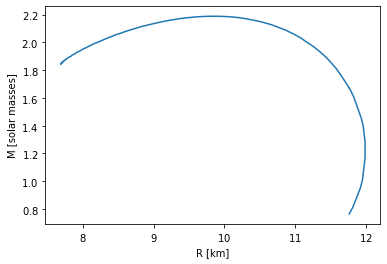

In [9]:
plt.plot(radius, mass)
plt.xlabel("R [km]")
plt.ylabel("M [solar masses]")
